#Variational Autoregreesive-flow Generator 
Description

This notebook allows to learn the probability distribution of any ising-like model defined by 

\begin{equation}
  \mathcal{H} = - \frac{1}{2} \sum_{ij} s_i J_{ij} s_j - \sum_i h_i s_i
\end{equation}
where the spins $s_i = \pm1$ and the matrix of interaction $J$ and the external field $h$ can take any form. 



We aim to learn the Boltzmann distribution of this system. For this, we perform a Hubbard-Stratonovich transformation on the probability. Defining $H = \beta h$ and $K = \beta \tilde{J}$ (where $\tilde{jJ}$ is the interaction matrix with supplementary diagonal terms to be positive definite) we obtain :

\begin{equation}
    p(\phi_1, \dots, \phi_N) = \frac{1}{Z} \exp \left(-\frac{1}{2} \sum_{i j} \phi_{i} K_{i j} \phi_{j}\right) \prod_{i} \cosh\left(H_i + \sum_{j} K_{i j} \phi_{j}\right)
\end{equation}


Since this distribution is not normalized (at least we do not know its normalization), one can not sample from it. 

Therefore, we define a parametrized autoregressive-flow model to learn it. The model is : 

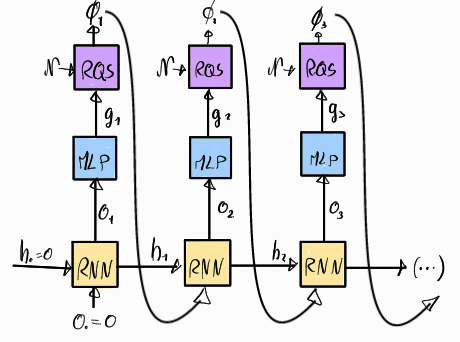

What this means is that we use a RNN (Vanilla, LSTM, GRU) that gets as input the previous component $\phi_{t-1}$ as input, whose output goes through a MLP to give the parameters of the distribution $q_\theta(\phi_t)$. This one consists of a gaussian random variable, which goes through multiple transformations, mainly a rational quadratic spline. 

Then the goal is to train this model so that $q_\theta(\phi)$ gets as close to $p(\phi)$ as possible. For this, we use as a loss the reveresed Kl-Divergence :

\begin{equation}
  \mathcal{L} = D_{KL}(Q_\theta || P) = \mathbb{E}_{\phi \sim q_\theta} \left [ \log \frac{q_\theta(\phi)}{p(\phi)}\right ].
\end{equation}

The optimization is done using gradient descent. 

## Imports

In [21]:
!pip install jax
!pip install jaxlib

!pip install --upgrade pip # To support manylinux2010 wheels.
!pip install --upgrade jax jaxlib # CPU-only
!pip install flax
!pip install --upgrade git+https://github.com/google/flax.git

!pip install distrax
!pip install --upgrade distrax

!pip install git+https://github.com/deepmind/dm-haiku
!pip install --upgrade haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-vvvb12fm
  Running command git clone --filter=blob:none --quiet https://github.com/google/flax.git /tmp/pip-req-build-vvvb12fm
  Resolved https://github.com/google/flax.git to commit e1712906e28e4ae4291b1fe9f96957a5919136ba
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/col

In [22]:
!git clone https://github.com/lindamauron/TP-IV
import sys
sys.path.insert(0,'/content/TP-IV')

fatal: destination path 'TP-IV' already exists and is not an empty directory.


In [23]:
import numpy as np 
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp
import jax.random as rnd
key = rnd.PRNGKey(12)

from jax import jit, vmap, grad
import flax.linen as nn
from jax.config import config; config.update("jax_enable_x64", True)
from jax.core import NamedShape
from jax.tree_util import tree_map


from functools import partial

try:
    from tqdm.auto import tqdm  # progressbar
except ImportError:
    tqdm = lambda x: x

from typing import Any, Callable, Sequence

import distrax
from distrax._src.bijectors.scalar_affine import ScalarAffine


import optax

import haiku as hk


import MCMC

import itertools
import numpy.linalg


import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 5)

# To import/export informations
import pickle

## Model

In [24]:
##################################### LSTM #####################################
class LSTM_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers1, mlp_layers2, name='LSTM_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.LSTM(hidden_size=hidden_size, name=name) #shared weights

    self.number_layers = number_layers
    
    self.mlp1 = hk.nets.MLP(
        mlp_layers1,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP1'
        )
    self.mlp2 = hk.nets.MLP(
        mlp_layers2,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP2'
        )

  def __call__(self,inputs, previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain through two different MLPs
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden,Ns), cell: (hidden,Ns)]

    return : outputs (number_layers, Ns, mlp_layers1[-1]) & (number_layers, Ns, mlp_layers2[-1]) & LSTMState
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])

    o, previous_state = self.rnn(inputs, previous_state)

    # return outputs and the final states (to go on if needed)
    return self.mlp1(o), self.mlp2(o), previous_state

################################### Vanilla ####################################
class Vanilla_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers1, mlp_layers2, name='Vanilla_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.VanillaRNN(hidden_size=hidden_size, name=name) #shared weights

    self.number_layers = number_layers
    
    self.mlp1 = hk.nets.MLP(
        mlp_layers1,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP1'
        )
    self.mlp2 = hk.nets.MLP(
        mlp_layers2,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP2'
        )

  def __call__(self,inputs, previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain through two different MLPs
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden,Ns), cell: (hidden,Ns)]

    return : outputs (number_layers, Ns, mlp_layers1[-1]) & (number_layers, Ns, mlp_layers2[-1]) & VanillaState
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])

    o, previous_state = self.rnn(inputs, previous_state)

    # return outputs and the final states (to go on if needed)
    return self.mlp1(o), self.mlp2(o), previous_state

##################################### GRU ######################################
class GRU_Module(hk.Module):
  def __init__(self, hidden_size, number_layers, mlp_layers1, mlp_layers2, name='GRU_module'):
    '''
    hidden_size : size of each input/output
    number_layers : number of times the RNN is called (corresponds to the number of particles)
    mlp_layers : the layers of the MLP
    '''
    super().__init__(name=name)
    self.rnn = hk.GRU(
        hidden_size=hidden_size,
        w_i_init = hk.initializers.RandomNormal(1,0), 
        w_h_init = hk.initializers.RandomNormal(1,0), 
        b_init = hk.initializers.Constant(0),
        name=name
        ) #shared weights

    self.number_layers = number_layers
    
    self.mlp1 = hk.nets.MLP(
        mlp_layers1,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP1'
        )
    self.mlp2 = hk.nets.MLP(
        mlp_layers2,
        activation = jax.nn.tanh, 
        w_init = hk.initializers.VarianceScaling(1.0, "fan_in",  "truncated_normal"), #hk.initializers.RandomNormal(1,0),
        b_init = hk.initializers.Constant(0), 
        name = 'MLP2'
        )

  def __call__(self,inputs, previous_state=None):
    '''
    Returns a list of outputs o in the RNN chain through two different MLPs
    inputs : intial entry of the RNN (o0), shape : (Ns, hidden_size)
    previous_state : previous state of the netowrk [hidden: (hidden,Ns), cell: (hidden,Ns)]

    return : outputs (number_layers, Ns, mlp_layers1[-1]) & (number_layers, Ns, mlp_layers2[-1]) & GRUState
    '''
    # Prepare states
    if previous_state is None:
      previous_state = self.rnn.initial_state(inputs.shape[0])

    o, previous_state = self.rnn(inputs, previous_state)

    # return outputs and the final states (to go on if needed)
    return self.mlp1(o), self.mlp2(o), previous_state
  

########################### Function to hk.transform ###########################
def module_fn(Module, hidden_size, number_layers, mlp_layers1, mlp_layers2, inputs, previous_state):
  '''
  Forwards the RNN + MLP network

  Module : module to use for the RNN (can be Vanilla_MLP_Module or LSTM_MLP_Module)
  hidden_size : size of each input/output
  number_layers : number of times the RNN is called (corresponds to the number of particles)
  mlp_layers : the layers of the MLP
  inputs : intial entry of the RNN (o0), shape : (Ns,)

  returns : outputs of the modules (number_layers, Ns, mlp_layers1[-1]) & (number_layers, Ns, mlp_layers2[-1]) & ModuleState
  '''
  module = Module(hidden_size, number_layers, mlp_layers1, mlp_layers2)
  return module(inputs, previous_state)


In [25]:
class Recurrent_Model:
  '''
  Defines the Autoregressive-flows model used.
  Each RNN cell (all with same parameters) gives two outputs, which define the 
  parameters for the distribution for one componenet (the RQS and the shift 
  respectively). Once the component is drwan from this distribution, it serves 
  as the input for the next component. 
  '''
  def __init__(self, key, Module, hidden_size, n_particles, mlp_layers1, mlp_layers2, p):
    '''
    key : random key to intialize the parameters
    Module : Recurrent Module used (LSTM_Module, Vanilla_Module or GRU_Module)
    hidden_size : size of the hidden vectors
    n_particles : number of outputs / variables = number of particles
    mlp_layers1 : layers of the MLP block for the spline (last layer MUST be 3*nbins+1)
    mlp_layers2 : layers of the MLP block for the shift (last layer MUST be 1)
    p : distribution to learn (MUST have a log_prob) 
    '''
    assert mlp_layers1[-1] % 3 == 1
    assert mlp_layers2[-1] == 1

    # The neural network (RNN -> MLP1,MLP2 -> g1,g2,prevous_sate)
    self.NN = hk.without_apply_rng(hk.transform(lambda inputs, previous_state : module_fn(
        Module = Module,
        hidden_size = hidden_size, 
        number_layers = n_particles, 
        mlp_layers1 = mlp_layers1, 
        mlp_layers2 = mlp_layers2,
        inputs = inputs, 
        previous_state = previous_state
    ) ))
    
    # Initialize the corresponding parameters
    self.params = self.NN.init(rng=key, inputs=np.zeros(shape=(1,1) ), previous_state=None)
    key, _ = rnd.split(key, 2)

    # Probability to learn
    self.p = p
    # Number of particles (components)
    self.n_particles = n_particles


  @partial(jit, static_argnums = (0,3))
  def sample_and_log_q(self, key, params, Ns):
    '''
    Draws samples from the distribution defined by params

    key : random key to sample
    params : parameters of the distribution q_theta
    Ns : number of samples

    returns : samples (Ns,n_particles) & their log_probabilities (Ns,)
    '''
    # To contain the important information
    log_probs = jnp.zeros(shape=(Ns,))
    phi = []

    ## t = 0 (special since here we sample Ns times from the same spline)
    o = np.zeros(shape=(1,Ns))
    previous_state = None
    g1, g2, previous_state = self.NN.apply( params, inputs=o.T, previous_state=previous_state ) #shapes (Ns,mlp[-1])
    
    # Distribution of phi0
    bij = distrax.Chain([ 
                        distrax.ScalarAffine( shift = g2[:,0], scale=np.ones(shape=(Ns,)) ) ,
                        distrax.Inverse( distrax.Tanh() ), 
                        distrax.RationalQuadraticSpline(g1, -1.0, 1.0),
                        distrax.Tanh(),
                      ])
    
    q = distrax.Transformed( distrax.Normal(np.zeros(Ns),np.ones(Ns)), 
                              bij
                              )
    
    # sample, save and input for the next one 
    o, log_p = q._sample_n_and_log_prob(key, 1)
    key, _ = rnd.split(key, 2)
    log_probs += jnp.squeeze(log_p, axis=0)
    phi.append( o )
    

    ## for t>0, we sample one time for each of the Ns distributions created (different splines)
    for t in range(1,self.n_particles):
      g1, g2, previous_state = self.NN.apply( params, inputs=o.T, previous_state=previous_state ) #shapes (Ns,mlp[-1])


      # Chain([f,g]) -> f(g(x))
      bij = distrax.Chain([ 
                          distrax.ScalarAffine( shift = g2, scale=np.ones(shape=(Ns,1,)) ) ,
                          distrax.Inverse( distrax.Tanh() ), 
                          distrax.RationalQuadraticSpline(jnp.expand_dims(g1, axis=1), -1.0, 1.0), #expand_dims to have Ns different splines
                          distrax.Tanh(),
                        ])
      

      q = distrax.Transformed( distrax.Normal(loc=jnp.zeros((Ns,1)), scale=jnp.ones((Ns,1))), # to have Ns samples drawn independently
                              bij
                              )
      
      o, log_p = q._sample_n_and_log_prob(key, 1)
      key, _ = rnd.split(key, 2)

      # cancel the additional dim
      o = jnp.squeeze(o, axis=-1)
      log_probs += jnp.squeeze(log_p, axis=(0,-1))
      phi.append( o )

    # Transform to the shape we wished (Ns,n_parts)
    data = jnp.squeeze( jnp.array(phi), axis=1).T


    return data, log_probs


  @partial(jit, static_argnums = (0,3))
  def sample(self, key, Ns):
    '''
    Draws samples from the distribution distribution with actual parameters

    key : random key to sample
    Ns : number of samples

    returns : samples (Ns,n_particles)
    '''
    # To contain the important information
    phi = []

    ## t = 0 (special since here we sample Ns times from the same spline)
    o = np.zeros(shape=(1,Ns))
    previous_state = None
    g1, g2, previous_state = self.NN.apply( self.params, inputs=o.T, previous_state=previous_state ) #shapes (Ns,mlp[-1])
    
    # Distribution of phi0
    bij = distrax.Chain([ 
                        distrax.ScalarAffine( shift = g2[:,0], scale=np.ones(shape=(Ns,)) ) ,
                        distrax.Inverse( distrax.Tanh() ), 
                        distrax.RationalQuadraticSpline(g1, -1.0, 1.0),
                        distrax.Tanh(),
                      ])
    
    q = distrax.Transformed( distrax.Normal(np.zeros(Ns),np.ones(Ns)), 
                              bij
                              )
    
    # sample, save and input for the next one 
    o = q._sample_n(key, 1)
    key, _ = rnd.split(key, 2)
    phi.append( o )
    

    ## for t>0, we sample one time for each of the Ns distributions created (different splines)
    for t in range(1,self.n_particles):
      g1, g2, previous_state = self.NN.apply( self.params, inputs=o.T, previous_state=previous_state ) #shapes (Ns,mlp[-1])


      # Chain([f,g]) -> f(g(x))
      bij = distrax.Chain([ 
                          distrax.ScalarAffine( shift = g2, scale=np.ones(shape=(Ns,1,)) ) ,
                          distrax.Inverse( distrax.Tanh() ), 
                          distrax.RationalQuadraticSpline(jnp.expand_dims(g1, axis=1), -1.0, 1.0), #expand_dims to have Ns different splines
                          distrax.Tanh(),
                        ])
      

      q = distrax.Transformed( distrax.Normal(loc=jnp.zeros((Ns,1)), scale=jnp.ones((Ns,1))), # to have Ns samples drawn independently
                              bij
                              )
      
      o = q._sample_n(key, 1)
      key, _ = rnd.split(key, 2)

      # cancel the additional dim
      o = jnp.squeeze(o, axis=-1)
      phi.append( o )

    # Transform to the shape we wished (Ns,n_parts)
    data = jnp.squeeze( jnp.array(phi), axis=1).T


    return data

    

  @partial(jit, static_argnums = (0,3))
  def loss(self, key, params, Ns):
    '''
    Computes the loss of the model L = D_KL(Q||P)

    key : random key to sample
    params : parameters of the distribution
    Ns : number of samples

    returns : loss ()
    '''
    data, logq = self.sample_and_log_q(key, params, Ns) #(Ns, n_particles) & (Ns,)


    logp = self.p.log_prob(data) #(Ns,)
    #l = jnp.mean( logq * (0.5*logq - logp), axis=0 )

    return jnp.mean(logq-logp, axis=0)

  @partial(jit, static_argnums = (0,3))
  def loss_and_grad(self, key, params, Ns):
    '''
    Computes the loss and its gradient
    
    key : random key to sample
    params : parameters of the distribution q_theta
    Ns : number of samples

    Returns : loss () and gradient of the loss (params-like)
    '''
    value, grad_L = jax.value_and_grad(self.loss, argnums=1, has_aux=False)(key, params, Ns)


    return value, grad_L

## Distribution to learn

In [26]:
def generate_field(N, beta, h, dim=1):
  '''
  Generates the external field matrix H for a homogeneous field
  
  N : number of particles
  beta : inverse temperature of the system
  h : amplitude of the field
  dim : numer of dimensions (default 1)

  returns : H matrix (N,)
  '''
  assert dim==1 or dim==2 or dim==3

  return beta*h*np.ones( N**dim )


def generate_interactions(N, beta, jnn, jnnn, dim=1, pbc=True):
  '''
  Generates the interaction matrices (multiplied by beta) for the second 
  neighbours model on a square lattice.

  N : number of particles
  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  jnnn : amplitude of the second neighbour interaction
  dim : numer of dimensions (default 1)
  pbc : if the system presents periodic boundary conditions (default True)

  returns : modified interaction matrix K (N,N) & standard one J (N,N)
  '''
  assert dim==1 or dim==2 or dim==3

  # Nearest neighbours
  T = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1)

  # Boundary conditions
  if pbc : 
    T[0,N-1] = 1
    T[N-1,0] = 1

  if dim == 1 : 
    '''
    Nearest neighbours in (+/-a)
    Second neighbours in (+/-2a)
    '''
    NNN = np.diag(np.ones(N-2), 2) + np.diag(np.ones(N-2), -2)
    if pbc : 
        NNN[0,N-2] = 1
        NNN[N-2,0] = 1
    J = jnn*T + jnnn*NNN
  if dim == 2:
    '''
    Nearest neighbours in (+/-a,0), (0,+/-a)
    Second neighbours in (+/-a,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = jnn*np.kron(I,T) + jnn*np.kron(T,I) + jnnn*np.kron(T,T)
  if dim == 3:
    '''
    Nearest neighbours in (+/- a,0,0), (0,+/- a,0), (0,0,+/- a)
    Second neighbours in (+/-a,+/-a,0), (+/-a,0,+/-a), (0,+/-a,+/-a)
    '''
    I = np.diag( np.ones(N) )
    J = jnn*( np.kron(np.kron(I, T), I) + np.kron(np.kron(T, I), I) + np.kron(I, np.kron(I,T)) )
    J += jnnn*( np.kron(np.kron(T, I), T) + np.kron(np.kron(I, T), T) + np.kron(T, np.kron(T,I)) )

  # Construct J and K
  if jnnn ==0:
    diag = 2.5*dim*beta*np.abs(jnn)
  else : 
    diag = 6*dim*beta*max(np.abs(jnn),np.abs(jnnn))

  J = beta*J
  K = J +diag*np.diag(np.ones(N**dim))
  return K,J

In [99]:
class IsingDistribution:
  '''
  Probability distribution of the ising model for a given interaction matrix and external field
  H = - 0.5 * sum_ij s_i J_ij s_j - sum_i h_i s_i

  hint : j=1 is ferromagnetic, j=-1 is antiferromagnetic
  '''
  def __init__(self, N, J, K, H, beta):
    '''
    Initialises the model for the given interactions and fields. 

    N : number of particles (int)
    J : NxN array defining the interactions (multiplied by beta already)
    K : J with addititonal diagonal terms to be positive definite
    H : external field (multiplied by beta)
    '''
    # Verifying the shapes of the matrices
    assert J.shape == K.shape

    # Verifying that K is indeed positive definite
    assert (np.linalg.eigvalsh(K) > 0).all(), 'Add terms on diagonal of K to make it positive definite.'

    self.N = N
    self.J = J
    self.K = K
    self.H = H
    self.beta = beta

  def log_prob(self,data):
    '''
    Unnormalized log-probability in continuous space
    data : samples for which one computes the prob (Ns,N)

    return : log(p(phi)), shape (Ns,)
    '''
    # Exponential part
    p = -0.5*jnp.einsum('...j,jk,...k', data, self.K, data )
    
    # Product of i part (separating the log(cosh) for stability)
    x = jnp.einsum('jk,...k', self.K, data ) + self.H
    p += jnp.sum( jnp.abs(x) + jnp.log1p(jnp.exp(-2*jnp.abs(x))) , axis=-1 )
      
    return p

  def discrete_log_prob(self, spins):
    '''
    Unnormalized log-probability in the spin space
    spins : spin samples (Ns,N)

    return : log(p(s)) = -beta*E(s), shape (Ns,)
    '''
    return 0.5*np.einsum('ni,ik,nk->n', spins, self.J, spins) + np.einsum('k,nk->n', self.H, spins)


  def componentwise_magn(self, data):
    '''
    Computes the magnetization of each component for a bunch of data
    data : data sampled over which to average (Ns,N)

    return : magnetization (N,)
    '''
    g = np.tanh( np.einsum('jk,nk->nj', self.K, data ) + self.H )

    return np.mean(g, axis=0)

  def mean_magnetization(self, data):
    '''
    Computes the mean magnetization over all components
    data : data sampled over which to average (Ns,N)

    return : mean magnetization ()
    '''
    g = np.tanh( np.einsum('jk,...k', self.K, data ) + self.H ).mean(axis=-1)

    return np.mean(g, axis=0)


  def correlations(self, data, i=0): #OK
    '''
    Computes the correlations between the spin i and the other spins (also itself)
    data : data sampled over which to average (Ns,N)
    i : component w.r.t. which to compute the correlations

    return : array of correlations (N,)
    '''
    m = np.tanh( np.einsum('jk,nk->nj', self.K, data ) + self.H )

    g = np.einsum('n,nk->nk',m[:,i], m)

    g[:,i] = 1.0

    return np.mean(g, axis=0)

  def magnetic_suscpetibility(self, data):
    '''
    Computes the magnetic susceptibility of the system
    data : data sampled over which to average (Ns,N)

    return : magnetic susceptibility ()
    '''
    # All local derivatives
    m = np.tanh( np.einsum('jk,nk->nj', self.K, data ) + self.H )

    # Correlalions
    corrs = np.mean( np.einsum('ni,nj->nij', m, m), axis=0)
    np.fill_diagonal(corrs, 1.0) #self correlations are always 1

    return beta**2/N**2 * np.sum(corrs)


  def energy(self, data):
    '''
    Computes the mean energy of the system
    data : data sampled over which to average (Ns,N)

    return : energy ()
    '''
    # All local derivatives
    m = np.tanh( np.einsum('jk,nk->nj', self.K, data ) + self.H )

    # Correlations
    corrs = np.mean( np.einsum('ni,nj->nij', m, m), axis=0)
    # change the diagonal to correct energy shift
    np.fill_diagonal(corrs, 0)
    interactions = np.einsum('ij,ij->', corrs, K)

    # Magnetizations
    ext_field = np.einsum('i,ni->n', H, m)


    E = np.mean(-0.5*interactions - ext_field, axis=0)
    return E/beta
    
def Z(beta,jnn,h):
  '''
  Computes the exact partition function for a 1D lattice with nearest neighbours-interaction

  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  h : amplitude of the field

  return : partition function ()
  '''
  # Verify if the model is corresponds
  dim = np.log(H.shape)/np.log(N)
  assert dim == 1

  # Transfer matrix eigenvalues
  a = jnp.exp(beta*jnn)*jnp.cosh(beta*h)
  sq = jnp.sqrt( jnp.exp(2*beta*jnn)*jnp.sinh(beta*h)**2 + jnp.exp(-2*beta*jnn) )

  return (a+sq)**N + (a-sq)**N

def energy_th(beta,jnn,h):
  '''
  Computes the exact mean energy for a 1D lattice with nearest neighbours-interaction

  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  h : amplitude of the field

  return : mean energy <E> ()
  '''
  return -jax.grad(Z,argnums=0)(beta,jnn,h) / Z(beta,jnn,h)

def magn_th(beta,jnn,h):
  '''
  Computes the exact magnetization for a 1D lattice with nearest neighbours-interaction

  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  h : amplitude of the field

  return : magnetization M ()
  '''
  return jax.grad(Z, argnums=2)(beta,jnn,h)/Z(beta,jnn,h)/beta/N

def susc_th(beta,jnn,h):
  '''
  Computes the exact magnetic susceptibility for a 1D lattice with nearest neighbours-interaction

  beta : inverse temperature of the system
  jnn : amplitude of the first neighbour interaction
  h : amplitude of the field

  return : magnetic susceptibility χ ()
  '''
  return -jax.grad(Z,argnums=1)(beta,jnn,h)/Z(beta,jnn,h) * beta**2/N

## Learn and observe

In [ ]:
################################################################################
# Distribution
N = 2
d = 1
pbc = True

beta = 1
h = 1
jnn = -1
jnnn = 0

H = generate_field(N=N, 
                   beta=beta, 
                   h=h, 
                   dim = d
                   )
K, J = generate_interactions(N=N, 
                             beta=beta, 
                             jnn=jnn, 
                             jnnn=jnnn, 
                             dim=d, 
                             pbc=pbc
                             )
p = IsingDistribution(N=N,
                      J=J,
                      K=K,
                      H=H,
                      beta=beta
                      )

if N == 2:
  size = 51
  x = np.linspace(-4, 4, size)
  probs_p = np.zeros( (size,size) )
  for k in range(size):
      for j in range(size):
          probs_p[k,j] = p.log_prob( np.array( [[x[k],x[j]]] ) )


  plt.title('p to learn')

  plt.contourf(x, x, np.exp(probs_p), levels=10)
  plt.contour(x, x, np.exp(probs_p), colors='black', levels=10, linewidths=.5, linestyles='solid')

  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')

  Z = np.trapz(np.trapz(np.exp(probs_p), x=x), x=x)
  Z

In [ ]:
################################################################################
# Model
hidden_size=10
nbins = 3
mlp_layers1 = [5,3*nbins+1]
mlp_layers2 = [6,4,1]


key = rnd.PRNGKey(2)


model = Recurrent_Model(key, Module=LSTM_Module, hidden_size=hidden_size, n_particles=N, mlp_layers1=mlp_layers1, mlp_layers2=mlp_layes2, p=p)
key, _ = rnd.split(key, 2)


# Learning parameters
nsteps = 45000
lr = 5e-3
Ns = 30000
tx = optax.sgd(learning_rate=lr)
opt_state = tx.init(model.params)


L = np.zeros(nsteps)
for i in tqdm(range(30000,nsteps)):
  L[i], g = model.loss_and_grad(key, model.params, Ns)
  key, _ = rnd.split(key, 2)


  if jnp.abs(L[i]) == np.infty or jnp.isnan(L[i]):
    print(g)
    break

  updates, opt_state = tx.update(g, opt_state)
  model.params = optax.apply_updates(model.params, updates)

  # Keep track of evolution
  if i % 200 == 0:
    print(i, 'Loss = ', L[i])
    
  
  # See loss for the last 500 steps
  if i%500==0 and i>0 :
    plt.figure()
    plt.plot(range(i-500, i), L[i-500:i])
    plt.show()
  
  '''
  # See distribution (if N==2)
  if (i+1)%500 == 0 or i==0:
    
    size = 21
    x = np.linspace(-5, 5, size)
    probs_q = np.zeros( (size,size) )
    for k in range(size):
      for j in range(size):
        probs_q[k,j] = model.log_prob( model.params, np.array([[x[k], x[j]]]) )

    plt.contourf(x, x, np.exp(probs_q), levels=20)
    plt.contour(x, x, np.exp(probs_q), colors='black', levels=20, linewidths=.5, linestyles='solid')
    print( np.trapz(np.trapz(np.exp(probs_q), x=x), x=x) )
    plt.show()

  '''

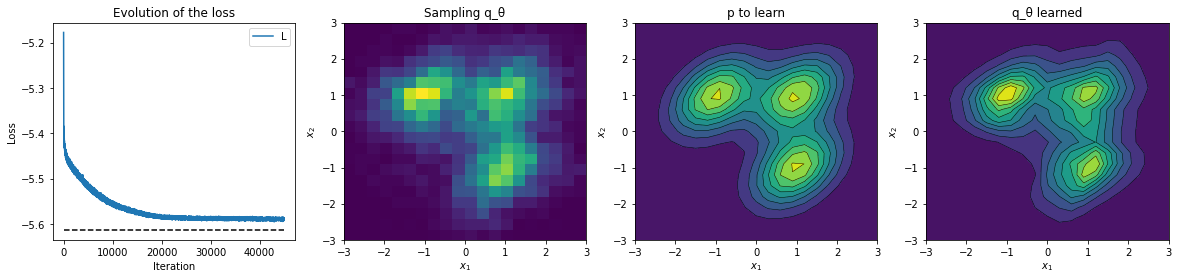

In [47]:
plt.figure(figsize=(20,4))

################################################################################
plt.subplot(1,4,1)
plt.title('Evolution of the loss')
plt.plot(L[L!=0], label='L')
plt.hlines(y=-5.6134, xmin=0, xmax=i, color='k', linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()


if N ==2 :
  ##############################################################################
  data = model.sample(key, params, Ns=10000)


  size = 21
  hist, yedges, xedges = np.histogram2d(data[:,0], 
                                    data[:,1], 
                                    bins=[np.linspace(-3,3,size),np.linspace(-3,3,size)]
                                    )
  X, Y = np.meshgrid(xedges, yedges)

  plt.subplot(1,4,2)
  plt.title('Sampling q_θ')

  plt.pcolormesh(X, Y, hist)

  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')


  ##############################################################################

  size = 21
  x = np.linspace(-3, 3, size)
  probs_p = np.zeros( (size,size) )
  probs_q = np.zeros( (size,size) )
  for k in range(size):
      for j in range(size):
          probs_p[k,j] = model.p.log_prob( np.array( [[x[k],x[j]]] ) )
          probs_q[k,j] = model.log_prob( model.params, np.array([[x[k],x[j]]]) )



  plt.subplot(1,4,3)
  plt.title('p to learn')

  plt.contourf(x, x, np.exp(probs_p), levels=10)
  plt.contour(x, x, np.exp(probs_p), colors='black', levels=10, linewidths=.5, linestyles='solid')

  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')


  ##############################################################################

  plt.subplot(1,4,4)
  plt.title('q_θ learned')

  plt.contourf(x, x, np.exp(probs_q), levels=10)
  plt.contour(x, x, np.exp(probs_q), colors='black', levels=10, linewidths=.5, linestyles='solid')

  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')

if N == 1:
  data = model.sample(key, params, Ns=10000)


  idx = jnp.argsort(data)


  plt.subplot(1,4,2)
  plt.title('Sampling q_θ')
  hst = plt.hist(x, label='q_θ', bins=20)

  

  qmax = jnp.max(hst[0])
  probs_p = jnp.exp( p.log_prob(x[idx]) )
  
  C = qmax/jnp.max(probs_p)
  A = jnp.max(probs_p)/np.exp( jnp.max(logq) )

  plt.plot(x[idx], C*probs_p ,label='p')
  plt.legend()

  ##############################################################################
  plt.subplot(1,4,3)
  plt.title('Probabilities')
  plt.plot(x[idx], jnp.exp( logq[idx] ), label='q_θ')
  plt.plot(x[idx], jnp.exp( p.log_prob(x[idx]) )/A,label='p')
  plt.legend()



plt.savefig(f'Ising_jnn={jnn}_jnnn={jnnn}_h={h}.png', dpi=200, bbox_inches='tight')
plt.show()

In [53]:
# Export parameters 

path = f'Loss_N={N}_jnn={jnn}_jnnn={jnnn}_h={h}.pickle'
with open(path, 'wb') as file:
    pickle.dump(L, file)

path = f'Parameters_N={N}_jnn={jnn}_jnnn={jnnn}_h={h}.pickle'
with open(path, 'wb') as file:
    pickle.dump(model.params, file)

path = f'HyperParams_N={N}_jnn={jnn}_jnnn={jnnn}_h={h}.txt'
sample = open(path, 'w')
print(f'hidden_size : {hidden_size}', file=sample)
print(f'mlp_layers1 : {mlp_layers1}', file=sample)
print(f'mlp_layers2 : {mlp_layers1}', file=sample)
print(f'p : N={N}, h={h}, jnn={jnn}, jnnn={jnnn}, beta={beta}', file=sample)



"\nwith open(path, 'rb') as file:\n    data = pickle.load(file)\n"

## Load a converged model

In [94]:
# First, look at the 'Hyperparametesr_()...).txt' you are interested in
################################################################################
# Distribution
N = 10
d = 1
pbc = True

beta = 1
h = 0
jnn = 1
jnnn = 0

H = generate_field(N=N, 
                   beta=beta, 
                   h=h, 
                   dim = d
                   )
K, J = generate_interactions(N=N, 
                             beta=beta, 
                             jnn=jnn, 
                             jnnn=jnnn, 
                             dim=d, 
                             pbc=pbc
                             )
p = IsingDistribution(N=N,
                      J=J,
                      K=K,
                      H=H,
                      beta=beta
                      )
################################################################################
# Model
hidden_size=10
nbins = 3
mlp_layers1 = [5,3*nbins+1]
mlp_layers2 = [6,4,1]


key = rnd.PRNGKey(2)


model = Recurrent_Model(key, Module=LSTM_Module, hidden_size=hidden_size, n_particles=N, mlp_layers1=mlp_layers1, mlp_layers2=mlp_layes2, p=p)
key, _ = rnd.split(key, 2)



################################################################################
# Load consequently
path = f'Loss_N={N}_jnn={jnn}_jnnn={jnnn}_h={h}.pickle'
with open(path, 'rb') as file:
    L = pickle.load(file)

path = f'Parameters_N={N}_jnn={jnn}_jnnn={jnnn}_h={h}.pickle'
with open(path, 'rb') as file:
    model.params = pickle.load(file)



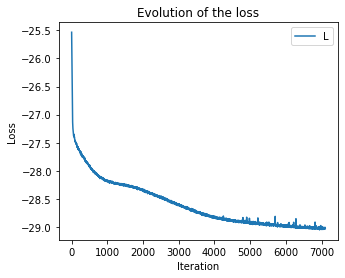

In [79]:
plt.figure(figsize=(5,4))

plt.title('Evolution of the loss')
plt.plot(L[L!=0], label='L')

# if we know the normalization (even numerically)
#plt.hlines(y=-np.log(Z), xmin=0, xmax=len(L), color='k', linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()


#plt.savefig(f'Ising_jnn={jnn}_h={h}.png', dpi=200, bbox_inches='tight')
plt.show()

# Testing the converged model

## MCMC

In [30]:
# Functions for the MCMC 
def log_prob(phi):
  '''
  Unnormalized log-probability in the continuous space

  phis : variable at which to calculate the prob (Ns,N)

  return : log_p(phis) (Ns,)
  '''

    # Exponential part
    p = -0.5 * phi.T @ K @ phi
    
    # Product of i part
    x = H + K@phi
    p += np.sum( np.abs(x) + np.log1p(np.exp(-2*np.abs(x))) )    
        
    return p

    
def discrete_prob(s):
  '''
  Unnormalized log-probability in the spin space

  s : spin chains

  return log_p(s) (Ns,)
  '''
  return 0.5*s.T @ J @ s + H@s


In [80]:
# Continous and discrete space MCMC to compare the results !
n_MCMC = int(1e6)

# continuous
phi0 = np.random.normal(0, 5, size=N)
sampler = MCMC.Continuous(std=1.7)
cont_samples = sampler.run(phi0, log_prob, n_MCMC)

# discrete
s0 = np.random.choice([-1.0, 1.0], N )
discrete_engine = MCMC.Discrete()
discrete_samples = discrete_engine.run(s0, discrete_prob, n_MCMC)


# cancel burning time
cont_samples = cont_samples[2000:]
discrete_samples = discrete_samples[2000:]

Acceptance rate : 0.461368
Acceptance rate : 0.204965


In [ ]:
# Function to estimate the observables using MCMC
def cont_M_array(phis):
  '''
  Calculates the componentwise magnetization in continuous space

  phis : continuous samples over which to compute

  return : <σ_i> (N,)
  '''
  m = np.tanh(H[0] + K[0]@phis.T )/N
  for i in range(1,N):
    m += np.tanh(H[i] + K[i]@phis.T )/N
  return m

def cont_M_mean(s):
    '''
  Calculates the average magnetization in continuous space

  phis : continuous samples over which to compute

  return : M = 1/N sum <σ_i> (N,)
  '''
  return np.mean(cont_M_array(s))

def discrete_M_array(s):
  '''
  Calculates the componentwise magnetization in discrete space

  s : spin samples over which to compute

  return : <σ_i> (N,)
  '''
  return np.mean(s, axis = 1)

def discrete_M_mean(s):
  '''
  Calculates the componentwise magnetization in discrete space

  s : spin samples over which to compute

  return : <σ_i> (N,)
  '''
  return np.mean( discrete_M_array(s) )




## Our model

In [81]:
# sample from the converged distribution
data = model.sample(key, int(1e6))


In [85]:
# Magnetization

print('Mean magnetization : ', 
      model.p.mean_magnetization(data), 
      cont_M_mean(cont_samples), 
      discrete_M_mean(discrete_samples),
      magn_th(beta,jnn,h) 
      )


print('Relative error : ', np.abs(model.p.mean_magnetization(data)-magn_th(beta,jnn,h))/magn_th(beta,jnn,h))

Mean magnetization :  0.030240153666084253 -0.023742434100680745 0.004975751503006009 0.0
relative error :  inf


Correlations 0 :  [1.         0.77967242 0.68345557 0.64829201 0.62521543 0.60598582
 0.59024345 0.57609468 0.56774708 0.63704972] [0.79225807 0.64573815 0.54476194 0.49328538 0.47953804 0.49625081
 0.55274251 0.65434716 0.79465348] [0.79501202 0.64988778 0.55429058 0.49550301 0.47617836 0.49562926
 0.55299198 0.65158517 0.79816633]


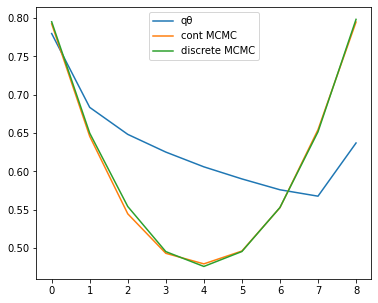

Correlations 1 :  [0.77967242 1.         0.80739864 0.71733119 0.67389025 0.64339127
 0.61683899 0.59295876 0.57081456 0.58148308] 0.792258071775311 0.7950120240480962


In [88]:
# Correlations
cont_corr0 = np.zeros( N-1 )
discrete_corr0 = np.zeros( N-1 )

for i in range(1,N):
  cont_corr0[i-1] = np.mean( np.tanh(H[0] + K[0]@cont_samples.T)*np.tanh(H[i] + K[i]@cont_samples.T), axis=0 )
  discrete_corr0[i-1] = np.mean( discrete_samples[:,0] * discrete_samples[:,i] )


# No theoretical solution to compare with...
print('Correlations 0 : ', 
      model.p.correlations(data,i=0), 
      cont_corr0, 
      discrete_corr0, 
      )

plt.figure()
plt.plot(p.correlations(data,i=0)[1:], label='qθ')
plt.plot(cont_corr0, label='cont MCMC')
plt.plot(discrete_corr0, label='discrete MCMC')
plt.legend()
plt.show()

In [90]:
# Energys

E_discrete = np.mean( -p.discrete_log_prob(discrete_samples)/beta )

print('Energy : ', 
      model.p.energy(data), 
      E_discrete, 
      energy_th(beta,jnn,h)
      )

print('relative error : ', (model.p.energy(data)-energy_th(beta,jnn,h))/energy_th(beta,jnn,h))

Energy :  -8.039525513352944 -7.947434869739479 -7.95566108942635
relative error :  0.010541477695430672


In [101]:
# Magnetic susceptibility

sisj = np.mean(np.einsum('ni,nj->nij', discrete_samples, discrete_samples), axis=0)
print('Susceptibility : ', 
      model.p.magnetic_suscpetibility(data), 
      np.mean(sisj), 
      susc_th(beta,jnn,h)
      )

print('relative error : ', (model.p.magnetic_suscpetibility(data)-susc_th(beta,jnn,h))/susc_th(beta,jnn,h))

Susceptibility :  0.725007579811315 0.6452284168336674 -0.795566108942635
relative error :  0.08868971206566025


In [ ]:
£